In [18]:
from jedi.api.refactoring import inline
from matplotlib import pyplot as plt
import argparse
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

In [19]:
def load_data(file_path):
    """
    Load the enriched data with weather and additional features.
    """
    df = pd.read_csv(file_path)
    # 假设这些列为最终的标签与特征列
    # 目标列：arrival_minutes_after_noon
    # 去除不需要的列
    # 根据实际情况调整
    drop_cols = ['Date','Week Day','Arrival Time']
    df = df.drop(columns=drop_cols, errors='ignore')
    # 确保没有缺失值，对缺失值进行填充
    # 更新后的写法
    df = df.ffill().bfill()
    return df

In [20]:
def get_features_and_target(df):
    """
    将DataFrame分为特征X和目标y。
    """
    # 假设arrival_minutes_after_noon为目标变量
    y = df['arrival_minutes_after_noon']
    X = df.drop(columns=['arrival_minutes_after_noon'])
    return X, y

In [21]:
def train_random_forest(X, y):
    """
    使用GridSearchCV对随机森林进行参数搜索和训练。
    """
    # 定义参数网格，可根据需要修改
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 5]
    }

    # 使用时间序列分割作为示例（如果你的数据有时间顺序）
    tscv = TimeSeriesSplit(n_splits=3)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    print("Best Parameters for RandomForest:", grid_search.best_params_)

    # 使用最后的分割进行性能评估
    y_pred = best_model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    print(f"RandomForest MAE on entire set: {mae:.2f}")
    return best_model, mae


In [22]:
def train_lightgbm(X, y):
    """
    使用GridSearchCV对LightGBM进行参数搜索和训练。
    """
    param_grid = {
        'model__num_leaves': [31, 50, 100],
        'model__learning_rate': [0.1, 0.05, 0.01],
        'model__n_estimators': [100, 200, 300]
    }

    tscv = TimeSeriesSplit(n_splits=3)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LGBMRegressor(random_state=42))
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    print("Best Parameters for LightGBM:", grid_search.best_params_)

    y_pred = best_model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    print(f"LightGBM MAE on entire set: {mae:.2f}")
    return best_model, mae

Training RandomForest...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters for RandomForest: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
RandomForest MAE on entire set: 0.21
Training completed.


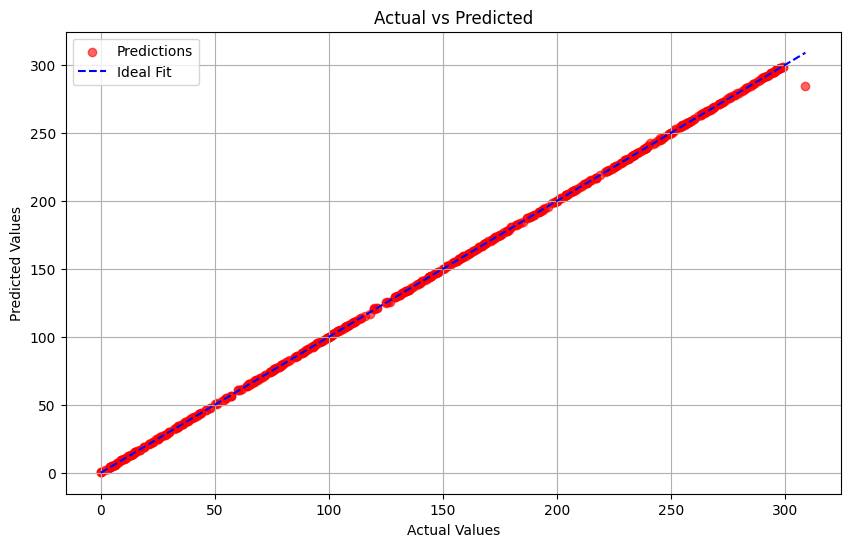

In [24]:
if __name__ == "__main__":
    # 模拟命令行参数
    args = argparse.Namespace(
        model='rf',  # 选择 'rf' 或 'lgbm'
        file='bus_arrival_schedule_with_weather.csv'  # 文件路径
    )

    df = load_data(args.file)
    X, y = get_features_and_target(df)

    if args.model.lower() == 'rf':
        print("Training RandomForest...")
        model, mae = train_random_forest(X, y)
    elif args.model.lower() == 'lgbm':
        print("Training LightGBM...")
        model, mae = train_lightgbm(X, y)
    else:
        print("Invalid model selected. Choose 'rf' or 'lgbm'.")
        exit(1)

    print("Training completed.")

    # 绘制预测 vs 实际值的图像
    y_pred = model.predict(X)
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.6, color='red', label='Predictions')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='blue', label='Ideal Fit')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()